In [1]:
import os
import random
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import gc
import numpy as np

from transformers import PaliGemmaForConditionalGeneration
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoProcessor
from peft import PeftModel


from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
import wandb

import matplotlib.pyplot as plt

/home/proven/PycharmProjects/term-project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [4]:
OUTPUT_DIR = "./paligemma-finetune-12-06-0034-cot"  

MODEL_ID = "google/paligemma2-3b-mix-224"
is_cot = True

if is_cot:
    CAPTION_ANNOTATIONS_FILE = '../dataset_with_steps_svo.csv'
    TARGET_CAPTION_COLUMNS = ['cot_response']
else:
    CAPTION_ANNOTATIONS_FILE = '../dataset/RISCM/processed_captions.csv'
    TARGET_CAPTION_COLUMNS = ['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5']

IMAGE_FOLDER = '../dataset/RISCM/resized'
IMAGE_COL_NAME = 'image'

print(CAPTION_ANNOTATIONS_FILE)

SPLIT_COL_NAME = 'split'
TRAIN_TARGET_SPLIT = 'train'
VAL_TARGET_SPLIT = 'val'

../dataset_with_steps_svo.csv


In [5]:
MAX_TRAIN_SAMPLES = 60000
MAX_VAL_SAMPLES = 8000
MAX_TARGET_CAPTION_LENGTH = 100
IGNORE_INDEX = -100

## Data Loading

This creates a custom PyTorch dataset class that inherits from Dataset to handle image-caption data pairs for training VLM.

In [6]:
class CaptionDataset(Dataset):
    def __init__(self, dataframe, image_folder):
        self.dataframe = dataframe.reset_index(drop=True)
        self.processor = processor  
        self.image_folder = image_folder
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_filename = row["image"]
        image_path = os.path.join(self.image_folder, image_filename)
        caption = row["cot_response"]
        image = Image.open(image_path).convert("RGB")  # Convert here
        return {"image": image, "caption": caption}

This loads the caption annotations CSV file into a pandas dataframe and resets the index to ensure clean sequential numbering for data access. Filters the dataframe to get only training split data, selects image and caption columns, and creates a sample of 4000 random examples with a fixed random seed for reproducibility.
Similarly filters for validation split data and creates a smaller sample of 400 examples for validation.

In [7]:
df_total = pd.read_csv(CAPTION_ANNOTATIONS_FILE).reset_index(drop=True)

def choose_random_caption(row):
    return np.random.choice([
        row['caption_1'], row['caption_2'], row['caption_3'], row['caption_4'], row['caption_5']
    ])

# df = df_total[['source', 'split', 'image']].copy()
df = df_total[['split', 'image', 'original_caption', 'cot_response']].copy()

# df['caption'] = df_total.apply(choose_random_caption, axis=1)

train_ds = df[df[SPLIT_COL_NAME] == TRAIN_TARGET_SPLIT][['image', 'cot_response']].reset_index(drop=True)
train_ds_sample = train_ds.sample(n=4000, random_state=42)
test_ds  = df[df[SPLIT_COL_NAME] == VAL_TARGET_SPLIT][['image', 'cot_response']].reset_index(drop=True)
test_ds_sample = test_ds.sample(n=400, random_state=42)

## Processor Initialization

Loads the pre-trained processor from the specified model ID, which handles both image preprocessing (resizing, normalization) and text tokenization to prepare inputs in the format expected by the vision-language model.

In [8]:
processor = AutoProcessor.from_pretrained(MODEL_ID)

## Dataset Creation

Instantiates the custom CaptionDataset class for both training and evaluation, passing the sampled dataframes and image folder path to create PyTorch datasets that can load and preprocess image-caption pairs during model training.

In [9]:
train_dataset = CaptionDataset(train_ds_sample, IMAGE_FOLDER)
eval_dataset = CaptionDataset(test_ds_sample, IMAGE_FOLDER)

In [10]:
print(len(train_dataset))
print(len(eval_dataset))

4000
400


Defines a custom batch processing function that combines multiple training examples into a single batch by creating structured prompts with special tokens, extracting captions as labels, ensuring images are in RGB format, and using the processor to tokenize everything into tensors with proper padding, then converting to bfloat16 precision and moving to the specified device for efficient training.

In [11]:
def collate_fn(examples):
    prompt = """Describe [subject: noun] and [object: noun] of this image. Then, provide the image description [final caption: sentence]"""
    
    texts = [f"<image> <bos> + {prompt}" for example in examples]
    labels= [example['caption'] for example in examples]
    images = [example["image"].convert("RGB") for example in examples]
    tokens = processor(text=texts, 
                       images=images, 
                       suffix=labels, 
                       return_tensors="pt", 
                       padding="longest")
    tokens = tokens.to(torch.bfloat16).to(device)
    
    return tokens

In [12]:
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

In [13]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

model_dtype = torch.bfloat16 if device.type == 'cuda' else torch.float32

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


## Lora and Quantization Configuration

It sets up 4-bit quantization using BitsAndBytesConfig to reduce memory usage by loading the model in 4-bit precision with NF4 quantization type and bfloat16 compute dtype, to fit the model in limited GPU memory.
Also, it configures LoRA for parameter-efficient fine-tuning by targeting specific attention and MLP projection layers with rank 8.

In [14]:
bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16
)
lora_config = LoraConfig(
      r=8,
      target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
      task_type="CAUSAL_LM",
)

Loads the PaliGemma conditional generation model from the pretrained checkpoint with 4-bit quantization enabled. Wraps the quantized model with PEFT (Parameter-Efficient Fine-Tuning) using the LoRA configuration, enabling efficient fine-tuning by only updating a small subset of parameters while keeping the base model frozen. LoRA dramatically reduces the number of parameters to be trained.

In [15]:
model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, 
                                                          quantization_config=bnb_config, 
                                                          device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


trainable params: 11,876,352 || all params: 3,044,118,768 || trainable%: 0.3901


Vision Tower Freezing: Freezes all parameters in the vision tower (image encoder) component by setting requires_grad to False, preventing these pretrained visual features from being updated during fine-tuning to preserve learned image representations.
Projector Freezing: Similarly freezes the multi-modal projector parameters that bridge vision and language representations, keeping this alignment layer fixed while allowing only the language components to adapt to the new captioning task.

In [16]:
for param in model.vision_tower.parameters():
    param.requires_grad = False
    
for param in model.multi_modal_projector.parameters():
    param.requires_grad = False

In [17]:
from transformers import TrainingArguments
from transformers import Trainer

In [18]:
model = model.to(torch.bfloat16)

## Training Parameter Configuration

In [19]:
log_interval = 10
learning_rate = 2e-5
num_epochs = 3
batch_size = 1
optim = "adamw_8bit"
warmup_steps = 2
weight_decay=1e-6
adam_beta2=0.999
save_steps=100
gradient_accumulation_steps=4
adam_beta1=0.9                       
adam_beta2=0.999
save_total_limit = 4
eval_steps=50
lr_scheduler_type="cosine"    
max_grad_norm=1.0
MAX_TARGET_CAPTION_LENGTH = 40

In [20]:
wandb.login(key="4ebe3345f2ce5ae98fdde78ea55a1a07aa23fc6d")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/proven/.netrc
wandb: Currently logged in as: ovguyo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [21]:
LORA_R = 8
LORA_ALPHA = 16
LORA_TARGET_MODULES = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"]

## Wandb Initialization

In [22]:
wandb.init(
    project="paligemma-decoder-only",
    config={
        "learning_rate": learning_rate, "epochs": num_epochs, "batch_size": batch_size,
        "model_id": MODEL_ID, "lora_r": LORA_R, "lora_alpha": LORA_ALPHA,
        "lora_target_modules": LORA_TARGET_MODULES, 
        "lr_scheduler_type": lr_scheduler_type,   "weight_decay": weight_decay, "optim": optim,
        "max_target_caption_length": MAX_TARGET_CAPTION_LENGTH,
         "seed": SEED,    }
)
wandb.define_metric("train/step_loss", step_metric="trainer/global_step")
wandb.define_metric("train/epoch_avg_loss", step_metric="epoch")
wandb.define_metric("val/epoch_avg_loss", step_metric="epoch")

In [23]:
args=TrainingArguments(
      num_train_epochs=num_epochs,
      per_device_train_batch_size=batch_size,
      gradient_accumulation_steps=4,
      warmup_steps=15,
      learning_rate=learning_rate,
      adam_beta1=0.9,                        
      adam_beta2=0.999,
      weight_decay=0.01,
      logging_steps=20,
      optim="adamw_8bit",
      save_strategy="steps",
      save_steps=100,
      save_total_limit=5,
      output_dir=OUTPUT_DIR,
      fp16=False,
      bf16=True,
      dataloader_pin_memory=False,
      remove_unused_columns=False,
      eval_strategy="steps",                
      eval_steps=200,
      per_device_eval_batch_size=2,
      load_best_model_at_end=False,
      metric_for_best_model="loss",
      greater_is_better=False,
      lr_scheduler_type="cosine",           
      max_grad_norm=1.0,  
)

In [24]:
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    args=args
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
200,1.047400,1.007897
400,0.857100,0.961679
600,0.750200,0.938283
800,0.749700,0.911878
1000,0.730200,0.897904
1200,0.661100,0.906576
1400,0.710900,0.894546
1600,0.710600,0.892301
1800,0.685900,0.887078
2000,0.689800,0.887555


TrainOutput(global_step=3000, training_loss=0.7716936575571696, metrics={'train_runtime': 7297.6136, 'train_samples_per_second': 1.644, 'train_steps_per_second': 0.411, 'total_flos': 5.805339359590656e+16, 'train_loss': 0.7716936575571696, 'epoch': 3.0})

## Inference

In [4]:
def generate_caption(model, processor, image_path, prompt, device, model_dtype, generation_config):
    """Generate a caption for a single image."""
    try:
        # Load and process image
        image = Image.open(image_path).convert('RGB')

        # Process inputs
        inputs = processor(
            text=[prompt],
            images=image,
            return_tensors="pt",
            padding="longest",
            truncation=True
        )

        # Move to device
        pixel_values = inputs["pixel_values"].to(device)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        if device.type == 'cuda':
            pixel_values = pixel_values.to(model_dtype)

        # Generate caption
        with torch.no_grad():
            outputs = model.generate(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                **generation_config
            )

        # Decode the generated caption
        # Remove the input tokens to get only the generated part
        generated_tokens = outputs[0][input_ids.shape[1]:]
        generated_caption = processor.decode(generated_tokens, skip_special_tokens=True)
        print(generated_caption)
        print("-----")

        return generated_caption.strip()

    except Exception as e:
        print(f"Error generating caption for {image_path}: {e}")
        return ""


In [6]:
generation_config = {
    "max_new_tokens": 40,
    "length_penalty": -1.0,
    "do_sample": False,
    # "temperature": 1.0,
    # "top_p": 0.9,
    "repetition_penalty": 1.2,
    "num_beams": 2
}

In [7]:
base_model_path = "/home/proven/PycharmProjects/term-project/project/paligemma-base/models--google--paligemma2-3b-mix-224/snapshots/8e40ab4cc5df93dfb7fd2fff754bcdff8b62ee78"
checkpoint_path = "./paligemma-finetune-04-06-2234-cot/checkpoint-2800"
BASE_MODEL_ID = "google/paligemma2-3b-mix-224"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dtype = torch.bfloat16
load_in_4bit = True

# Quantization config
bnb_config = None
if load_in_4bit and device.type == 'cuda':
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=model_dtype,
    )
        
processor = AutoProcessor.from_pretrained(BASE_MODEL_ID)
model = PaliGemmaForConditionalGeneration.from_pretrained(
        base_model_path,
        torch_dtype=model_dtype,
        quantization_config=bnb_config,
        device_map="auto",
        local_files_only=True
    )

model = PeftModel.from_pretrained(model, checkpoint_path)
model = model.to(device)
model.eval()

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PaliGemmaForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipSdpaAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=8, bias=False)
                    )
                    (lora_B)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


[sub: noun] There are planes.
[obj: noun] Planes are parked.
[caption: sentence] There are two planes parked on the airport.
[caption: sentence]
-----
[sub: noun] There is a road.
[obj: noun] The road is next to the meadow.
[caption: sentence] There is a road next to the meadow.

-----


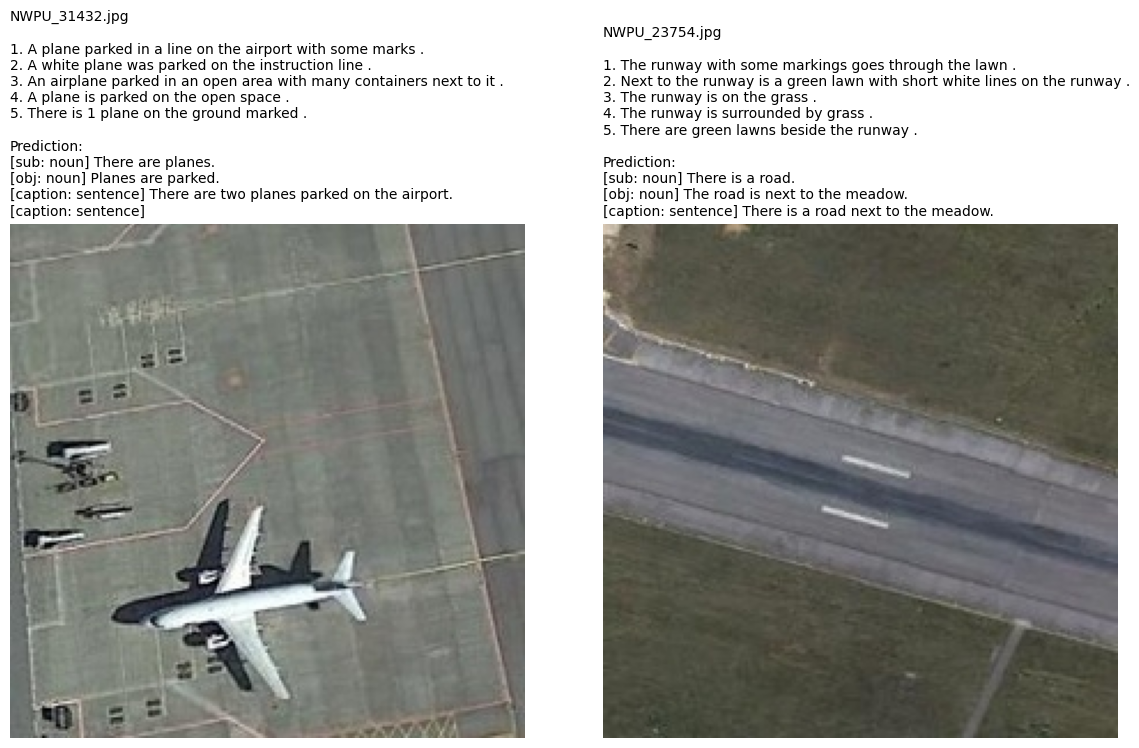

In [11]:
prompt = """Describe [subject: noun] and [object: noun] of this image. Then, provide the image description [final caption: sentence]"""

image_folder = "/home/proven/PycharmProjects/term-project/dataset/RISCM/resized"
image_col_name = 'image'
num_samples_to_show = 2
caption_columns = ['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5'] 
annotation_file = '../dataset/RISCM/captions.csv'

df = pd.read_csv(annotation_file)
test_df = df[df['split'] == 'test']
df.columns = test_df.columns.str.strip()
sample_df = test_df.sample(num_samples_to_show) # Get the first N samples

fig, axes = plt.subplots(1, num_samples_to_show, figsize=(6 * num_samples_to_show, 7))

if num_samples_to_show == 1:
    axes = [axes] 

for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_filename = row[image_col_name]
    img_path = os.path.join(image_folder, img_filename)
    img = Image.open(img_path)
    
    prediction = generate_caption(model, processor, img_path, prompt, device, model_dtype, generation_config)

    captions = [f"{j+1}. {str(row[caption_col])}" for j, caption_col in enumerate(caption_columns)]
    caption_text = "\n".join(captions)

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"{img_filename}\n\n{caption_text}\n\nPrediction:\n{prediction}", fontsize=10, loc='left')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Evaluation

Fine-tuned model on CoT dataset was laoded. evaluation script takes 2 arguments: checkpoint_path and is_cot boolean.

In [4]:
!python evaluate_paligemma.py "./paligemma-finetune-04-06-2234-cot/checkpoint-2800" 1

You passed: ./paligemma-finetune-04-06-2234-cot/checkpoint-2800
Loading processor from google/paligemma2-3b-mix-224...
Loading base model from google/paligemma2-3b-mix-224...
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:06<00:00,  3.28s/it]
Loading LoRA adapters from ./paligemma-finetune-04-06-2234-cot/checkpoint-2800...
Loading test data from ../dataset/RISCM/captions.csv...
Found 1000 examples for split 'test'.
Processed 1000 valid examples.

Generating captions for 1000 images...
Generating captions:   0%|                             | 0/1000 [00:00<?, ?it/s]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
Asking to truncate to max_length but no maximum length 

[sub: noun] There are planes.
[obj: noun] Planes are on the runway.
[caption: sentence] There are two planes on the runway.
[caption: sentence
-----
There are two planes on the runway.
Generating captions:   1%|▏                 | 13/1000 [00:51<1:04:07,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are planes.
[obj: noun] Planes are parked in the airport.
[caption: sentence] There are two planes parked in the airport.
[caption
-----
There are two planes parked in the airport.
Generating captions:   1%|▎                 | 14/1000 [00:55<1:04:00,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects specia

[sub: noun] There is a building.
[obj: noun] The building is next to a road.
[caption: sentence] There is a building next to a road.

-----
There is a building next to a road.
Generating captions:   3%|▍                 | 27/1000 [01:46<1:02:56,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are planes.
[obj: noun] Planes are in the airport.
[caption: sentence] There are many planes in the airport.
[caption: sentence
-----
There are many planes in the airport.
Generating captions:   3%|▌                 | 28/1000 [01:50<1:03:07,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in 

[sub: noun] There are planes.
[obj: noun] Planes are parked.
[caption: sentence] There are two planes parked in the airport.
[caption: sentence]
-----
There are two planes parked in the airport.
Generating captions:   4%|▋                 | 41/1000 [02:40<1:01:58,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a building.
[obj: noun] The building is near the airport.
[caption: sentence] There is a building near the airport.
[caption
-----
There is a building near the airport.
Generating captions:   4%|▊                 | 42/1000 [02:44<1:01:54,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects speci

[sub: noun] There are planes.
[obj: noun] Planes are on the runway.
[caption: sentence] There are two planes on the runway.
[caption: sentence
-----
There are two planes on the runway.
Generating captions:   6%|▉                 | 55/1000 [03:35<1:03:07,  4.01s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a plane.
[obj: noun] The plane is on the runway.
[caption: sentence] A plane is on the runway.
[caption:
-----
A plane is on the runway.
Generating captions:   6%|█                 | 56/1000 [03:39<1:02:30,  3.97s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many token

[sub: noun] There is a road.
[obj: noun] The road is next to the airport.
[caption: sentence] a road is next to the airport.
[
-----
a road is next to the airport.
Generating captions:   7%|█▏                | 69/1000 [04:30<1:00:18,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a plane.
[obj: noun] The plane is parked.
[caption: sentence] a plane is parked on the airport.
[caption: sentence
-----
a plane is parked on the airport.
Generating captions:   7%|█▎                | 70/1000 [04:34<1:00:15,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens a

[sub: noun] There is a building.
[obj: noun] The building is in the airport.
[caption: sentence] a building is in the airport.
[caption:
-----
a building is in the airport.
Generating captions:   8%|█▋                  | 82/1000 [05:20<59:26,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a river.
[obj: noun] The river is near airport.
[caption: sentence] There is a river near the airport.
[caption:
-----
There is a river near the airport.
Generating captions:   8%|█▋                  | 83/1000 [05:24<59:22,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many 

[sub: noun] There is a runway.
[obj: noun] The runway is in the airport.
[caption: sentence] There is a runway in the airport.
[caption
-----
There is a runway in the airport.
Generating captions:  10%|█▉                  | 96/1000 [06:15<58:29,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a river.
[obj: noun] The river is in the airport.
[caption: sentence] There is a river in the airport.
[caption
-----
There is a river in the airport.
Generating captions:  10%|█▉                  | 97/1000 [06:18<58:28,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many 

[sub: noun] There is a runway.
[obj: noun] The runway is in the forest.
[caption: sentence] There is a runway in the forest.
[caption
-----
There is a runway in the forest.
Generating captions:  11%|██                 | 110/1000 [07:09<57:46,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] Road is near airport.
[caption: sentence] There is a road near the airport.
[caption: sentence
-----
There is a road near the airport.
Generating captions:  11%|██                 | 111/1000 [07:13<57:42,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many

[sub: noun] There is a building.
[obj: noun] The building is near airport.
[caption: sentence] a building is near the airport.
[caption: sentence
-----
a building is near the airport.
Generating captions:  12%|██▎                | 123/1000 [08:00<56:48,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a runway.
[obj: noun] The runway is in the airport.
[caption: sentence] There is a runway in the airport.
[caption
-----
There is a runway in the airport.
Generating captions:  12%|██▎                | 124/1000 [08:04<56:41,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the te

[sub: noun] There is a building.
[obj: noun] The building is in the airport.
[caption: sentence] There is a building in the airport.
[caption
-----
There is a building in the airport.
Generating captions:  14%|██▌                | 136/1000 [08:50<55:56,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a runway.
[obj: noun] The runway is in the airport.
[caption: sentence] There is a runway in the airport.
[caption
-----
There is a runway in the airport.
Generating captions:  14%|██▌                | 137/1000 [08:54<55:52,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the te

[sub: noun] There is a baseball field.
[obj: noun] The field is next to a parking lot.
[caption: sentence] a baseball field is next to a parking
-----
a baseball field is next to a parking
Generating captions:  15%|██▊                | 149/1000 [09:41<55:10,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] The road is next to the baseball field.
[caption: sentence] There is a road next to the baseball field
-----
There is a road next to the baseball field
Generating captions:  15%|██▊                | 150/1000 [09:45<55:29,  3.92s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special 

[sub: noun] There is a field.
[obj: noun] The field is near a road.
[caption: sentence] a large field is near a road.
-----
a large field is near a road.
Generating captions:  16%|███                | 162/1000 [10:31<53:47,  3.85s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a baseball field.
[obj: noun] The field is surrounded by trees.
[caption: sentence] a baseball field is surrounded by many green trees.
-----
a baseball field is surrounded by many green trees.
Generating captions:  16%|███                | 163/1000 [10:35<53:54,  3.86s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens 

[sub: noun] There is a playground.
[obj: noun] The playground is next to a road.
[caption: sentence] a playground is next to a road.
-----
a playground is next to a road.
Generating captions:  18%|███▎               | 176/1000 [11:26<53:22,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a baseball field.
[obj: noun] The field is next to a parking lot.
[caption: sentence] There is a baseball field next to a
-----
There is a baseball field next to a
Generating captions:  18%|███▎               | 177/1000 [11:29<53:16,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, 

[sub: noun] There is a building.
[obj: noun] The building is surrounded by trees.
[caption: sentence] a building is surrounded by many green trees.
-----
a building is surrounded by many green trees.
Generating captions:  19%|███▌               | 190/1000 [12:20<52:25,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a playground.
[obj: noun] The playground is next to a parking lot.
[caption: sentence] a playground is next to a parking lot.
-----
a playground is next to a parking lot.
Generating captions:  19%|███▋               | 191/1000 [12:24<52:20,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expect

[sub: noun] There is a playground.
[obj: noun] The playground is next to a parking lot.
[caption: sentence] a playground is next to a parking lot.
-----
a playground is next to a parking lot.
Generating captions:  20%|███▉               | 204/1000 [13:15<51:54,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a building.
[obj: noun] The building is surrounded by trees.
[caption: sentence] a building is surrounded by many green trees.
-----
a building is surrounded by many green trees.
Generating captions:  20%|███▉               | 205/1000 [13:19<51:49,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expect

[sub: noun] There is a basketball court.
[obj: noun] The court is next to a parking lot.
[caption: sentence] There is a basketball court next to a
-----
There is a basketball court next to a
Generating captions:  22%|████               | 217/1000 [14:05<50:41,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a court.
[obj: noun] The court is next to a pond.
[caption: sentence] There is a basketball court next to a pond.
-----
There is a basketball court next to a pond.
Generating captions:  22%|████▏              | 218/1000 [14:09<50:38,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image 

[sub: noun] There is a court.
[obj: noun] Court is near trees.
[caption: sentence] There is a basketball court near some green trees.
-----
There is a basketball court near some green trees.
Generating captions:  23%|████▎              | 230/1000 [14:56<49:51,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] The road is next to basketball courts.
[caption: sentence] There is a road next to the basketball courts.
-----
There is a road next to the basketball courts.
Generating captions:  23%|████▍              | 231/1000 [15:00<49:53,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects

[sub: noun] There are trees.
[obj: noun] Trees are in the area.
[caption: sentence] There are many green trees in the area.
[caption:
-----
There are many green trees in the area.
Generating captions:  24%|████▌              | 243/1000 [15:46<48:59,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a basketball court.
[obj: noun] The court is next to the road.
[caption: sentence] There is a basketball court next to the road
-----
There is a basketball court next to the road
Generating captions:  24%|████▋              | 244/1000 [15:50<48:54,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special im

[sub: noun] There are trees.
[obj: noun] Trees are around basketball courts.
[caption: sentence] Some green trees are around two basketball courts.
-----
Some green trees are around two basketball courts.
Generating captions:  26%|████▊              | 256/1000 [16:37<48:18,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a pond.
[obj: noun] The pond is surrounded by trees.
[caption: sentence] There is a pond surrounded by many green trees.
-----
There is a pond surrounded by many green trees.
Generating captions:  26%|████▉              | 257/1000 [16:41<48:11,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The process

[sub: noun] There are two basketball courts.
[obj: noun] Courts are next to each other.
[caption: sentence] There are two basketball courts next to each other.
-----
There are two basketball courts next to each other.
Generating captions:  27%|█████              | 269/1000 [17:27<47:13,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] The basketball court.
[obj: noun] The court is surrounded by trees.
[caption: sentence] The basketball court is surrounded by many green trees.
[
-----
The basketball court is surrounded by many green trees.
Generating captions:  27%|█████▏             | 270/1000 [17:31<47:09,  3.88s/it]You are passing both `text` and `images`

[sub: noun] There are rocks.
[obj: noun] Rocks are on the beach.
[caption: sentence] There are many rocks on the beach.
[caption: sentence
-----
There are many rocks on the beach.
Generating captions:  28%|█████▎             | 282/1000 [18:18<46:34,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] The ocean.
[obj: noun] The ocean is blue.
[caption: sentence] The ocean is blue.
[caption: sentence] The ocean is blue
-----
The ocean is blue.
Generating captions:  28%|█████▍             | 283/1000 [18:21<46:28,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as th

[sub: noun] There is a beach.
[obj: noun] The beach is next to the sea.
[caption: sentence] There is a beach next to the sea.

-----
There is a beach next to the sea.
Generating captions:  30%|█████▌             | 296/1000 [19:12<45:38,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a river.
[obj: noun] The river is in the forest.
[caption: sentence] a river is in the forest.
[caption:
-----
a river is in the forest.
Generating captions:  30%|█████▋             | 297/1000 [19:16<45:33,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are ima

[sub: noun] There is a beach.
[obj: noun] The beach is next to the sea.
[caption: sentence] There is a beach next to the sea.

-----
There is a beach next to the sea.
Generating captions:  31%|█████▉             | 310/1000 [20:07<44:43,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a beach.
[obj: noun] The beach is near the ocean.
[caption: sentence] There is a beach near the ocean.
[caption
-----
There is a beach near the ocean.
Generating captions:  31%|█████▉             | 311/1000 [20:11<44:39,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as

[sub: noun] There is a beach.
[obj: noun] The beach is next to the sea.
[caption: sentence] There is a beach next to the sea.

-----
There is a beach next to the sea.
Generating captions:  32%|██████▏            | 324/1000 [21:01<43:52,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a beach.
[obj: noun] The beach is next to the sea.
[caption: sentence] There is a beach next to the sea.

-----
There is a beach next to the sea.
Generating captions:  32%|██████▏            | 325/1000 [21:05<43:45,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as ther

[sub: noun] There is a beach.
[obj: noun] The beach is next to the ocean.
[caption: sentence] There is a beach next to the ocean.

-----
There is a beach next to the ocean.
Generating captions:  34%|██████▍            | 338/1000 [21:56<42:58,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a beach.
[obj: noun] The beach is next to the ocean.
[caption: sentence] There is a beach next to the ocean.

-----
There is a beach next to the ocean.
Generating captions:  34%|██████▍            | 339/1000 [21:59<42:51,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many to

[sub: noun] There is a bridge.
[obj: noun] The bridge is on the river.
[caption: sentence] a bridge is on the river.
[caption:
-----
a bridge is on the river.
Generating captions:  35%|██████▋            | 352/1000 [22:50<42:12,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a bridge.
[obj: noun] The bridge is on the river.
[caption: sentence] a bridge is on the river.
[caption:
-----
a bridge is on the river.
Generating captions:  35%|██████▋            | 353/1000 [22:54<42:04,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per

[sub: noun] There is a bridge.
[obj: noun] The bridge is over the river.
[caption: sentence] There is a bridge over the river.
[caption
-----
There is a bridge over the river.
Generating captions:  37%|██████▉            | 366/1000 [23:45<41:04,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a bridge.
[obj: noun] The bridge is over the river.
[caption: sentence] a bridge is over the river.
[caption:
-----
a bridge is over the river.
Generating captions:  37%|██████▉            | 367/1000 [23:48<40:57,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens 

[sub: noun] There is a river.
[obj: noun] The river is in the center of the image.
[caption: sentence] There is a river in the center of
-----
There is a river in the center of
Generating captions:  38%|███████▏           | 380/1000 [24:39<40:09,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a bridge.
[obj: noun] The bridge is over the river.
[caption: sentence] a bridge is over the river.
[caption:
-----
a bridge is over the river.
Generating captions:  38%|███████▏           | 381/1000 [24:43<40:04,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens

[sub: noun] There is a bridge.
[obj: noun] The bridge is over a river.
[caption: sentence] a bridge is over a river.
[caption:
-----
a bridge is over a river.
Generating captions:  39%|███████▍           | 394/1000 [25:33<39:14,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a bridge.
[obj: noun] The bridge is over the river.
[caption: sentence] a bridge is over the river.
[caption:
-----
a bridge is over the river.
Generating captions:  40%|███████▌           | 395/1000 [25:37<39:09,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are imag

[sub: noun] There is a river.
[obj: noun] The river is surrounded by trees.
[caption: sentence] There is a river in the middle of the river surrounded
-----
There is a river in the middle of the river surrounded
Generating captions:  41%|███████▊           | 408/1000 [26:28<38:23,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a bridge.
[obj: noun] The bridge is over a river.
[caption: sentence] a bridge is over a river.
[caption:
-----
a bridge is over a river.
Generating captions:  41%|███████▊           | 409/1000 [26:32<38:18,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image token

[sub: noun] There is a piece of land.
[obj: noun] The land is bare.
[caption: sentence] "it is a piece of bare land."
-----
"it is a piece of bare land."
Generating captions:  42%|████████           | 422/1000 [27:22<37:32,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in the desert.
[caption: sentence] many green trees are in the desert.
[caption: sentence
-----
many green trees are in the desert.
Generating captions:  42%|████████           | 423/1000 [27:26<37:26,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as t

[sub: noun] There is a piece of land.
[obj: noun] The land is bare.
[caption: sentence] "it is a piece of bare land."
-----
"it is a piece of bare land."
Generating captions:  44%|████████▎          | 436/1000 [28:17<36:30,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are bushes.
[obj: noun] Bushes are in the desert.
[caption: sentence] There are many green bushes in the desert.
[caption
-----
There are many green bushes in the desert.
Generating captions:  44%|████████▎          | 437/1000 [28:21<36:27,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many token

[sub: noun] There is a road.
[obj: noun] The road is in the forest.
[caption: sentence] a road is in the forest.
[caption:
-----
a road is in the forest.
Generating captions:  45%|████████▌          | 450/1000 [29:11<35:59,  3.93s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] The road is in the forest.
[caption: sentence] a road is in the forest.
[caption:
-----
a road is in the forest.
Generating captions:  45%|████████▌          | 451/1000 [29:15<35:52,  3.92s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text

[sub: noun] There are trees.
[obj: noun] Trees are in the forest.
[caption: sentence] many green trees are in the forest.
[caption: sentence
-----
many green trees are in the forest.
Generating captions:  46%|████████▊          | 464/1000 [30:06<34:42,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in a meadow.
[caption: sentence] many green trees are in a meadow.
[caption: sentence
-----
many green trees are in a meadow.
Generating captions:  46%|████████▊          | 465/1000 [30:10<34:40,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the te

[sub: noun] There are trees.
[obj: noun] Trees are in the forest.
[caption: sentence] There are many green trees in the forest.
[caption:
-----
There are many green trees in the forest.
Generating captions:  48%|█████████          | 478/1000 [31:00<33:51,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in the forest.
[caption: sentence] many green trees are in the forest.
[caption: sentence
-----
many green trees are in the forest.
Generating captions:  48%|█████████          | 479/1000 [31:04<33:47,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens 

[sub: noun] The church.
[obj: noun] The church is surrounded by trees.
[caption: sentence] The church is surrounded by many green trees.
[caption:
-----
The church is surrounded by many green trees.
Generating captions:  49%|█████████▎         | 492/1000 [31:55<32:52,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a church.
[obj: noun] The church is next to the river.
[caption: sentence] There is a church next to the river.

-----
There is a church next to the river.
Generating captions:  49%|█████████▎         | 493/1000 [31:58<32:47,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image 

[sub: noun] There is a building.
[obj: noun] The building is near a road.
[caption: sentence] a building is near a road.
[caption:
-----
a building is near a road.
Generating captions:  50%|█████████▌         | 505/1000 [32:45<32:10,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a church.
[obj: noun] The church has a dome.
[caption: sentence] There is a church with a green dome in the square.
-----
There is a church with a green dome in the square.
Generating captions:  51%|█████████▌         | 506/1000 [32:49<32:05,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] There are many buildings in a commercial area.
[caption
-----
There are many buildings in a commercial area.
Generating captions:  52%|█████████▊         | 518/1000 [33:36<31:09,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are near a river.
[caption: sentence] some buildings are near a river.
[caption: sentence]
-----
some buildings are near a river.
Generating captions:  52%|█████████▊         | 519/1000 [33:40<31:07,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor exp

[sub: noun] There is a church.
[obj: noun] The church is surrounded by trees.
[caption: sentence] a church is surrounded by many green trees.
-----
a church is surrounded by many green trees.
Generating captions:  53%|██████████         | 531/1000 [34:26<30:24,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] many buildings are in a commercial area.
[caption:
-----
many buildings are in a commercial area.
Generating captions:  53%|██████████         | 532/1000 [34:30<30:20,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] There are many buildings in a commercial area.
[caption
-----
There are many buildings in a commercial area.
Generating captions:  54%|██████████▎        | 544/1000 [35:17<29:37,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] Road is near trees.
[caption: sentence] There is a road near many green trees.
-----
There is a road near many green trees.
Generating captions:  55%|██████████▎        | 545/1000 [35:21<29:32,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image t

[sub: noun] There is a building.
[obj: noun] The building is near trees.
[caption: sentence] a building is near some green trees.
-----
a building is near some green trees.
Generating captions:  56%|██████████▌        | 557/1000 [36:08<28:53,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] The church.
[obj: noun] The church is surrounded by buildings.
[caption: sentence] The church is surrounded by many buildings.
[caption: sentence
-----
The church is surrounded by many buildings.
Generating captions:  56%|██████████▌        | 558/1000 [36:12<28:44,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special i

[sub: noun] There is a farm.
[obj: noun] Farm is on the land.
[caption: sentence] a farm is on the land.
[caption: sentence
-----
a farm is on the land.
Generating captions:  57%|██████████▊        | 571/1000 [37:02<27:55,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in the forest.
[caption: sentence] many green trees are in the forest.
[caption: sentence
-----
many green trees are in the forest.
Generating captions:  57%|██████████▊        | 572/1000 [37:06<27:48,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as th

[sub: noun] There is a circle.
[obj: noun] Circle is in the square.
[caption: sentence] There is a circle in the square.
[caption:
-----
There is a circle in the square.
Generating captions:  58%|███████████        | 585/1000 [37:57<26:57,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a farm.
[obj: noun] Farm is near farmlands.
[caption: sentence] a farm is near some farmlands.
[caption:
-----
a farm is near some farmlands.
Generating captions:  59%|███████████▏       | 586/1000 [38:01<26:54,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there

[sub: noun] There is a farm.
[obj: noun] Farm is on the land.
[caption: sentence] There is a farm on the land.
[caption:
-----
There is a farm on the land.
Generating captions:  60%|███████████▍       | 599/1000 [38:51<26:00,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a piece of land.
[obj: noun] The land is green.
[caption: sentence] "it is a piece of green land."
-----
"it is a piece of green land."
Generating captions:  60%|███████████▍       | 600/1000 [38:55<26:07,  3.92s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each

[sub: noun] There is a meadow.
[obj: noun] The meadow is green.
[caption: sentence] "it is a piece of green meadow."
-----
"it is a piece of green meadow."
Generating captions:  61%|███████████▋       | 613/1000 [39:46<24:52,  3.86s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a farm.
[obj: noun] Farm is near a river.
[caption: sentence] a farm is near a river.
[caption: sentence
-----
a farm is near a river.
Generating captions:  61%|███████████▋       | 614/1000 [39:50<24:51,  3.86s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each 

[sub: noun] There is a farm.
[obj: noun] Farm is on the land.
[caption: sentence] a farm is on the land.
[caption: sentence
-----
a farm is on the land.
Generating captions:  63%|███████████▉       | 627/1000 [40:40<24:11,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a farm.
[obj: noun] Farm is surrounded by farmland.
[caption: sentence] a farm is surrounded by farmland.
[caption: sentence
-----
a farm is surrounded by farmland.
Generating captions:  63%|███████████▉       | 628/1000 [40:44<24:09,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as

[sub: noun] There are clouds.
[obj: noun] Clouds are in the sky.
[caption: sentence] many white clouds are in the sky.
[caption: sentence
-----
many white clouds are in the sky.
Generating captions:  64%|████████████▏      | 641/1000 [41:34<23:18,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a river.
[obj: noun] The river is in the forest.
[caption: sentence] There is a river in the forest.
[caption
-----
There is a river in the forest.
Generating captions:  64%|████████████▏      | 642/1000 [41:38<23:14,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many t

[sub: noun] There is a river.
[obj: noun] The river is in the forest.
[caption: sentence] There is a river in the forest.
[caption
-----
There is a river in the forest.
Generating captions:  67%|████████████▋      | 668/1000 [43:19<21:34,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a river.
[obj: noun] The river is in the forest.
[caption: sentence] There is a river in the forest.
[caption
-----
There is a river in the forest.
Generating captions:  67%|████████████▋      | 669/1000 [43:23<21:30,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as 

[sub: noun] There is a mountain.
[obj: noun] The mountain is bare.
[caption: sentence] "it is a piece of bare mountain."
-----
"it is a piece of bare mountain."
Generating captions:  68%|████████████▉      | 682/1000 [44:13<20:20,  3.84s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a mountain.
[obj: noun] The mountain is bare.
[caption: sentence] "it is a piece of bare mountain."
-----
"it is a piece of bare mountain."
Generating captions:  68%|████████████▉      | 683/1000 [44:17<20:21,  3.85s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images

[sub: noun] There is a cloud.
[obj: noun] Cloud is over the land.
[caption: sentence] There is a large white cloud over the land.
-----
There is a large white cloud over the land.
Generating captions:  70%|█████████████▏     | 696/1000 [45:07<19:43,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are clouds.
[obj: noun] Clouds are in the sky.
[caption: sentence] "many white clouds are in the sky."
-----
"many white clouds are in the sky."
Generating captions:  70%|█████████████▏     | 697/1000 [45:11<19:23,  3.84s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many token

[sub: noun] There are buildings.
[obj: noun] Buildings are near the river.
[caption: sentence] many buildings are near the river.
[caption: sentence]
-----
many buildings are near the river.
Generating captions:  71%|█████████████▍     | 710/1000 [46:02<18:49,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] The road.
[obj: noun] The road is surrounded by trees.
[caption: sentence] The road is surrounded by many green trees.
[caption:
-----
The road is surrounded by many green trees.
Generating captions:  71%|█████████████▌     | 711/1000 [46:06<18:44,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special 

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] Many buildings are in a commercial area.
[caption:
-----
Many buildings are in a commercial area.
Generating captions:  72%|█████████████▋     | 723/1000 [46:52<17:56,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] There are many buildings in a commercial area.
[caption
-----
There are many buildings in a commercial area.
Generating captions:  72%|█████████████▊     | 724/1000 [46:56<17:53,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The

[sub: noun] There is a river.
[obj: noun] The river is in the center of the area.
[caption: sentence] There is a river in the center of
-----
There is a river in the center of
Generating captions:  74%|█████████████▉     | 736/1000 [47:43<17:06,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] The road is near a building.
[caption: sentence] a road is near a building.
[caption:
-----
a road is near a building.
Generating captions:  74%|██████████████     | 737/1000 [47:47<17:01,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as th

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] many buildings are in a commercial area.
[caption:
-----
many buildings are in a commercial area.
Generating captions:  75%|██████████████▎    | 750/1000 [48:37<16:15,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] "there are many buildings in a commercial area."
-----
"there are many buildings in a commercial area."
Generating captions:  75%|██████████████▎    | 751/1000 [48:41<16:11,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The proc

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] many buildings are in a commercial area.
[caption:
-----
many buildings are in a commercial area.
Generating captions:  76%|██████████████▍    | 763/1000 [49:28<15:21,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a building.
[obj: noun] The building is near a road.
[caption: sentence] a building is near a road.
[caption:
-----
a building is near a road.
Generating captions:  76%|██████████████▌    | 764/1000 [49:32<15:17,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] "there are many buildings in a commercial area."
-----
"there are many buildings in a commercial area."
Generating captions:  78%|██████████████▋    | 776/1000 [50:18<14:30,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] There are many buildings in a commercial area.
[caption
-----
There are many buildings in a commercial area.
Generating captions:  78%|██████████████▊    | 777/1000 [50:22<14:26,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor

[sub: noun] The road.
[obj: noun] The road is surrounded by trees.
[caption: sentence] The road is surrounded by many green trees.
[caption:
-----
The road is surrounded by many green trees.
Generating captions:  79%|███████████████    | 790/1000 [51:13<13:36,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] There are many buildings in a commercial area.
[caption
-----
There are many buildings in a commercial area.
Generating captions:  79%|███████████████    | 791/1000 [51:17<13:32,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The process

[sub: noun] There is a pond.
[obj: noun] The pond is surrounded by trees.
[caption: sentence] There is a pond surrounded by many green trees.

-----
There is a pond surrounded by many green trees.
Generating captions:  80%|███████████████▎   | 803/1000 [52:03<12:49,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a residential area.
[caption: sentence] "there are many buildings in a residential area."
-----
"there are many buildings in a residential area."
Generating captions:  80%|███████████████▎   | 804/1000 [52:07<12:44,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The pro

[sub: noun] There is a building.
[obj: noun] The building is surrounded by trees.
[caption: sentence] a building is surrounded by many green trees.
-----
a building is surrounded by many green trees.
Generating captions:  82%|███████████████▌   | 816/1000 [52:54<11:59,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are buildings.
[obj: noun] Buildings are in a residential area.
[caption: sentence] "there are many buildings in a residential area."
-----
"there are many buildings in a residential area."
Generating captions:  82%|███████████████▌   | 817/1000 [52:58<11:55,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The 

[sub: noun] There are buildings.
[obj: noun] Buildings are in a commercial area.
[caption: sentence] many buildings are in a commercial area.
[caption:
-----
many buildings are in a commercial area.
Generating captions:  83%|███████████████▊   | 829/1000 [53:45<11:06,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a pond.
[obj: noun] The pond is surrounded by trees.
[caption: sentence] There is a pond surrounded by many green trees.
-----
There is a pond surrounded by many green trees.
Generating captions:  83%|███████████████▊   | 830/1000 [53:49<11:02,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor exp

[sub: noun] There is a piece of land.
[obj: noun] The land is bare.
[caption: sentence] "it is a piece of bare land."
-----
"it is a piece of bare land."
Generating captions:  84%|███████████████▉   | 842/1000 [54:35<10:14,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a desert.
[obj: noun] The desert is in the desert.
[caption: sentence] "it is a piece of desert."
-----
"it is a piece of desert."
Generating captions:  84%|████████████████   | 843/1000 [54:39<10:10,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. 

[sub: noun] There is a river.
[obj: noun] The river is in the desert.
[caption: sentence] a river is in the middle of the desert.
-----
a river is in the middle of the desert.
Generating captions:  86%|████████████████▎  | 856/1000 [55:30<09:22,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a river.
[obj: noun] The river is in the desert.
[caption: sentence] a river is in the middle of the desert.
-----
a river is in the middle of the desert.
Generating captions:  86%|████████████████▎  | 857/1000 [55:34<09:18,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as m

[sub: noun] There is a river.
[obj: noun] The river is in the forest.
[caption: sentence] There is a river in the forest.
[caption
-----
There is a river in the forest.
Generating captions:  87%|████████████████▌  | 870/1000 [56:24<08:23,  3.87s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is sand.
[obj: noun] Sand is on the beach.
[caption: sentence] There is a piece of sand on the beach.
[caption
-----
There is a piece of sand on the beach.
Generating captions:  87%|████████████████▌  | 871/1000 [56:28<08:20,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many token

[sub: noun] There is a desert.
[obj: noun] The desert is in the desert.
[caption: sentence] "it is a piece of desert."
-----
"it is a piece of desert."
Generating captions:  88%|████████████████▊  | 884/1000 [57:19<07:31,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a piece of land.
[obj: noun] The land is bare.
[caption: sentence] "it is a piece of bare land."
-----
"it is a piece of bare land."
Generating captions:  88%|████████████████▊  | 885/1000 [57:23<07:27,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. 

[sub: noun] The desert.
[obj: noun] The desert is red.
[caption: sentence] The desert is red.
[caption: sentence] The desert is red
-----
The desert is red.
Generating captions:  90%|█████████████████  | 898/1000 [58:13<06:36,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a desert.
[obj: noun] The desert is in the desert.
[caption: sentence] a piece of desert is in the desert.
[
-----
a piece of desert is in the desert.
Generating captions:  90%|█████████████████  | 899/1000 [58:17<06:32,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are

[sub: noun] There are trees.
[obj: noun] Trees are in the forest.
[caption: sentence] many green trees are in the forest.
[caption: sentence
-----
many green trees are in the forest.
Generating captions:  91%|█████████████████▎ | 912/1000 [59:08<05:42,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in a forest.
[caption: sentence] many green trees are in a forest.
[caption: sentence
-----
many green trees are in a forest.
Generating captions:  91%|█████████████████▎ | 913/1000 [59:12<05:38,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the te

[sub: noun] There is a forest.
[obj: noun] Forest is in the meadow.
[caption: sentence] "there is a forest in the meadow."
-----
"there is a forest in the meadow."
Generating captions:  93%|███████████████▋ | 926/1000 [1:00:02<04:47,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a piece of land.
[obj: noun] The land is bare.
[caption: sentence] "it is a piece of bare land."
-----
"it is a piece of bare land."
Generating captions:  93%|███████████████▊ | 927/1000 [1:00:06<04:43,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per

[sub: noun] There are plants.
[obj: noun] Plants are in the forest.
[caption: sentence] There are many green plants in the forest.
[caption:
-----
There are many green plants in the forest.
Generating captions:  94%|███████████████▉ | 940/1000 [1:00:57<03:54,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in the forest.
[caption: sentence] many green trees are in the forest.
[caption: sentence
-----
many green trees are in the forest.
Generating captions:  94%|███████████████▉ | 941/1000 [1:01:01<03:50,  3.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tok

[sub: noun] There are trees.
[obj: noun] Trees are in a forest.
[caption: sentence] many green trees are in a forest.
[caption: sentence
-----
many green trees are in a forest.
Generating captions:  95%|████████████████▏| 954/1000 [1:01:52<02:59,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There are trees.
[obj: noun] Trees are in a forest.
[caption: sentence] many green trees are in a forest.
[caption: sentence
-----
many green trees are in a forest.
Generating captions:  96%|████████████████▏| 955/1000 [1:01:56<02:55,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as

[sub: noun] The forest.
[obj: noun] The forest is green.
[caption: sentence] The forest is green.
[caption: sentence] The forest is green
-----
The forest is green.
Generating captions:  97%|████████████████▍| 968/1000 [1:02:46<02:04,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] The forest.
[obj: noun] The forest is green.
[caption: sentence] The forest is green.
[caption: sentence] The forest is green
-----
The forest is green.
Generating captions:  97%|████████████████▍| 969/1000 [1:02:50<02:00,  3.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there ar

[sub: noun] There is a road.
[obj: noun] Road is in forest.
[caption: sentence] There is a road in the forest.
[caption: sentence
-----
There is a road in the forest.
Generating captions:  98%|████████████████▋| 982/1000 [1:03:41<01:09,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] Road is in forest.
[caption: sentence] There is a road in the forest.
[caption: sentence
-----
There is a road in the forest.
Generating captions:  98%|████████████████▋| 983/1000 [1:03:44<01:06,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as ther

[sub: noun] There is a road.
[obj: noun] The road is next to the meadow.
[caption: sentence] a road is next to the meadow.
[
-----
a road is next to the meadow.
Generating captions: 100%|████████████████▉| 996/1000 [1:04:35<00:15,  3.88s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
[sub: noun] There is a road.
[obj: noun] The road is next to a parking lot.
[caption: sentence] There is a road next to a parking lot
-----
There is a road next to a parking lot
Generating captions: 100%|████████████████▉| 997/1000 [1:04:39<00:11,  3.89s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as

Fine-tuned model on original data was loaded.

In [12]:
!python evaluate_paligemma.py "./paligemma-finetune-25-05-2057/checkpoint-2950" 0

You passed: ./paligemma-finetune-25-05-2057/checkpoint-2950
Is CoT:  0
Loading processor from google/paligemma2-3b-mix-224...
Loading base model from google/paligemma2-3b-mix-224...
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:02<00:00,  1.00s/it]
Loading LoRA adapters from ./paligemma-finetune-25-05-2057/checkpoint-2950...
Loading test data from ../dataset/RISCM/captions.csv...
Found 1000 examples for split 'test'.
Processed 1000 valid examples.

Generating captions for 1000 images...
Generating captions:   0%|                             | 0/1000 [00:00<?, ?it/s]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
Asking to truncate to max_length but no maximum leng

There are three planes in the airport.
-----
There are three planes in the airport.
Generating captions:   2%|▎                   | 15/1000 [00:21<22:33,  1.37s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many planes on the ground.
-----
There are many planes on the ground.
Generating captions:   2%|▎                   | 16/1000 [00:22<21:30,  1.31s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how ma

There is a plane on the runway.
-----
There is a plane on the runway.
Generating captions:   3%|▌                   | 31/1000 [00:44<21:44,  1.35s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some buildings near the airport.
-----
There are some buildings near the airport.
Generating captions:   3%|▋                   | 32/1000 [00:46<20:36,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many

There are many planes parked at the airport.
-----
There are many planes parked at the airport.
Generating captions:   5%|▉                   | 47/1000 [01:05<21:55,  1.38s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some planes on the ground.
-----
There are some planes on the ground.
Generating captions:   5%|▉                   | 48/1000 [01:06<20:36,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will 

There is a plane on the ground.
-----
There is a plane on the ground.
Generating captions:   6%|█▎                  | 63/1000 [01:26<21:01,  1.35s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are two planes on the runway.
-----
There are two planes on the runway.
Generating captions:   6%|█▎                  | 64/1000 [01:27<19:51,  1.27s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each t

The runways of the airport are next to each other.
-----
The runways of the airport are next to each other.
Generating captions:   8%|█▌                  | 79/1000 [01:47<21:50,  1.42s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many runways at the airport.
-----
There are many runways at the airport.
Generating captions:   8%|█▌                  | 80/1000 [01:48<20:21,  1.33s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For thi

The airport is surrounded by a forest.
-----
The airport is surrounded by a forest.
Generating captions:  10%|█▉                  | 95/1000 [02:08<18:39,  1.24s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some buildings near the runway.
-----
There are some buildings near the runway.
Generating captions:  10%|█▉                  | 96/1000 [02:09<18:03,  1.20s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will in

There are many runways at the airport.
-----
There are many runways at the airport.
Generating captions:  11%|██                 | 111/1000 [02:34<21:47,  1.47s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings around the airport.
-----
There are many buildings around the airport.
Generating captions:  11%|██▏                | 112/1000 [02:35<20:36,  1.39s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we w

There are many buildings and roads near the airport.
-----
There are many buildings and roads near the airport.
Generating captions:  13%|██▍                | 127/1000 [02:55<19:30,  1.34s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The airport is surrounded by many trees.
-----
The airport is surrounded by many trees.
Generating captions:  13%|██▍                | 128/1000 [02:56<18:51,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that.

A baseball diamond is surrounded by trees.
-----
A baseball diamond is surrounded by trees.
Generating captions:  14%|██▋                | 143/1000 [03:16<17:42,  1.24s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many trees around the circle.
-----
There are many trees around the circle.
Generating captions:  14%|██▋                | 144/1000 [03:17<17:08,  1.20s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we wil

There are many trees around the golf course.
-----
There are many trees around the golf course.
Generating captions:  16%|███                | 159/1000 [03:36<17:37,  1.26s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There is a baseball diamond next to the road.
-----
There is a baseball diamond next to the road.
Generating captions:  16%|███                | 160/1000 [03:38<17:56,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For t

There are many baseball fields in the park.
-----
There are many baseball fields in the park.
Generating captions:  18%|███▎               | 175/1000 [03:57<17:41,  1.29s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some baseball fields on the lawn.
-----
There are some baseball fields on the lawn.
Generating captions:  18%|███▎               | 176/1000 [03:58<17:24,  1.27s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this ca

There are many baseball diamonds on the lawn.
-----
There are many baseball diamonds on the lawn.
Generating captions:  19%|███▌               | 190/1000 [04:19<19:30,  1.44s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some buildings and trees beside the playground.
-----
There are some buildings and trees beside the playground.
Generating captions:  19%|███▋               | 191/1000 [04:20<18:57,  1.41s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos

There is a baseball field next to some buildings.
-----
There is a baseball field next to some buildings.
Generating captions:  21%|███▉               | 206/1000 [04:42<24:20,  1.84s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some buildings beside the tennis court.
-----
There are some buildings beside the tennis court.
Generating captions:  21%|███▉               | 207/1000 [04:43<22:15,  1.68s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token

The parking lot is next to the basketball courts.
-----
The parking lot is next to the basketball courts.
Generating captions:  22%|████▏              | 222/1000 [05:02<16:53,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The basketball court is surrounded by trees.
-----
The basketball court is surrounded by trees.
Generating captions:  22%|████▏              | 223/1000 [05:04<16:13,  1.25s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after tha

There are many basketball courts in the parking lot.
-----
There are many basketball courts in the parking lot.
Generating captions:  24%|████▌              | 237/1000 [05:24<22:48,  1.79s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The basketball court is on the lawn. There are some trees beside the basketball court. The road is beside the basketball court.
-----
The basketball court is on the lawn. There are some trees beside the basketball court. The road is beside the basketball court.
Generating captions:  24%|████▌              | 238/1000 [05:28<28:23,  2.24s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image to

The basketball court is next to the tennis court.
-----
The basketball court is next to the tennis court.
Generating captions:  25%|████▊              | 252/1000 [05:46<15:56,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The parking lot is next to the basketball court.
-----
The parking lot is next to the basketball court.
Generating captions:  25%|████▊              | 253/1000 [05:47<16:07,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token a

There are many basketball courts on the ground.
-----
There are many basketball courts on the ground.
Generating captions:  27%|█████              | 267/1000 [06:07<16:34,  1.36s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
A basketball court is surrounded by buildings.
-----
A basketball court is surrounded by buildings.
Generating captions:  27%|█████              | 268/1000 [06:08<15:40,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after tha

The beach is next to some green trees.
-----
The beach is next to some green trees.
Generating captions:  28%|█████▍             | 283/1000 [06:26<14:26,  1.21s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The beach is next to the sea. The sea is blue.
-----
The beach is next to the sea. The sea is blue.
Generating captions:  28%|█████▍             | 284/1000 [06:28<15:43,  1.32s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, 

The beach is next to the sea. The sea is blue.
-----
The beach is next to the sea. The sea is blue.
Generating captions:  30%|█████▋             | 299/1000 [06:51<17:35,  1.51s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The beach is next to the sea. 
-----
The beach is next to the sea.
Generating captions:  30%|█████▋             | 300/1000 [06:52<17:48,  1.53s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how

The beach is next to the sea. There are some trees on the beach.
-----
The beach is next to the sea. There are some trees on the beach.
Generating captions:  32%|█████▉             | 315/1000 [07:16<18:11,  1.59s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The beach is next to the sea. There are some buildings beside the beach.
-----
The beach is next to the sea. There are some buildings beside the beach.
Generating captions:  32%|██████             | 316/1000 [07:18<19:01,  1.67s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended 

The beach is next to the sea. The sea has waves.
-----
The beach is next to the sea. The sea has waves.
Generating captions:  33%|██████▎            | 331/1000 [07:40<16:36,  1.49s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings on the beach.
-----
There are many buildings on the beach.
Generating captions:  33%|██████▎            | 332/1000 [07:41<15:18,  1.37s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this ca

The beach is next to the ocean with waves.
-----
The beach is next to the ocean with waves.
Generating captions:  35%|██████▌            | 347/1000 [08:04<14:41,  1.35s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The beach is next to a piece of green land.
-----
The beach is next to a piece of green land.
Generating captions:  35%|██████▌            | 348/1000 [08:06<14:47,  1.36s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call

There is a bridge over the river.
-----
There is a bridge over the river.
Generating captions:  36%|██████▉            | 363/1000 [08:30<16:32,  1.56s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many green trees beside the river.
-----
There are many green trees beside the river.
Generating captions:  36%|██████▉            | 364/1000 [08:31<15:24,  1.45s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer 

There are some green trees beside the freeway.
-----
There are some green trees beside the freeway.
Generating captions:  38%|███████▏           | 378/1000 [08:59<24:29,  2.36s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many bridges across the river.
-----
There are many bridges across the river.
Generating captions:  38%|███████▏           | 379/1000 [09:00<20:33,  1.99s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this ca

A bridge over a river with some trees on either side.
-----
A bridge over a river with some trees on either side.
Generating captions:  39%|███████▍           | 394/1000 [09:25<13:14,  1.31s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There is a bridge over the river.
-----
There is a bridge over the river.
Generating captions:  40%|███████▌           | 395/1000 [09:26<12:35,  1.25s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this ca

There are some green trees beside the railway.
-----
There are some green trees beside the railway.
Generating captions:  41%|███████▊           | 409/1000 [09:50<13:14,  1.34s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings beside the river.
-----
There are many buildings beside the river.
Generating captions:  41%|███████▊           | 410/1000 [09:51<12:35,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For thi

The chaparral is consist of many different sizes of trees.
-----
The chaparral is consist of many different sizes of trees.
Generating captions:  42%|████████           | 424/1000 [10:22<28:05,  2.93s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The chaparral is consist of bare land and some green plants.
-----
The chaparral is consist of bare land and some green plants.
Generating captions:  42%|████████           | 425/1000 [10:24<26:00,  2.71s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very 

The sparse vegetation consists of many green plants.
-----
The sparse vegetation consists of many green plants.
Generating captions:  44%|████████▎          | 439/1000 [10:50<16:15,  1.74s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The chaparral forest is on the bare land.
-----
The chaparral forest is on the bare land.
Generating captions:  44%|████████▎          | 440/1000 [10:51<15:14,  1.63s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after tha

The desert is composed of yellow sand and some green plants.
-----
The desert is composed of yellow sand and some green plants.
Generating captions:  45%|████████▋          | 454/1000 [11:27<24:06,  2.65s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many green trees on the ground.
-----
There are many green trees on the ground.
Generating captions:  46%|████████▋          | 455/1000 [11:29<20:06,  2.21s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>`

The chaparral is consist of green trees. The chaparral is on the yellow bare land.
-----
The chaparral is consist of green trees. The chaparral is on the yellow bare land.
Generating captions:  47%|████████▉          | 470/1000 [11:52<17:48,  2.02s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The sparse vegetation consists of bare land and a few small trees. The bare land consists of bare land and a few small trees. The sparse vegetation is evenly distributed. The trees consist of green leaves and
-----
The sparse vegetation consists of bare land and a few small trees. The bare land consists of bare land and a few small trees. The sparse vegetation is evenly distributed. 

There are many pieces of sand on the beach.
-----
There are many pieces of sand on the beach.
Generating captions:  48%|█████████▏         | 484/1000 [12:23<19:01,  2.21s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many green trees on the desert.
-----
There are many green trees on the desert.
Generating captions:  48%|█████████▏         | 485/1000 [12:25<16:25,  1.91s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, 

There are some buildings near the road.
-----
There are some buildings near the road.
Generating captions:  50%|█████████▍         | 499/1000 [12:53<13:30,  1.62s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings and trees on the mountain.
-----
There are many buildings and trees on the mountain.
Generating captions:  50%|█████████▌         | 500/1000 [12:55<15:13,  1.83s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For

The church is surrounded by many buildings.
-----
The church is surrounded by many buildings.
Generating captions:  51%|█████████▊         | 514/1000 [13:15<12:24,  1.53s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings in the open space.
-----
There are many buildings in the open space.
Generating captions:  52%|█████████▊         | 515/1000 [13:17<13:36,  1.68s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this ca

The church is surrounded by some buildings.
-----
The church is surrounded by some buildings.
Generating captions:  53%|██████████         | 530/1000 [13:42<14:13,  1.82s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The church is surrounded by many trees. 
-----
The church is surrounded by many trees.
Generating captions:  53%|██████████         | 531/1000 [13:43<12:46,  1.63s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we 

There are many buildings of different shapes and sizes.
-----
There are many buildings of different shapes and sizes.
Generating captions:  55%|██████████▎        | 546/1000 [14:05<16:56,  2.24s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some trees beside the palace.
-----
There are some trees beside the palace.
Generating captions:  55%|██████████▍        | 547/1000 [14:06<14:33,  1.93s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after t

There are many circular farmlands in the field.
-----
There are many circular farmlands in the field.
Generating captions:  56%|██████████▋        | 562/1000 [14:25<09:15,  1.27s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some green circles and squares on the ground.
-----
There are some green circles and squares on the ground.
Generating captions:  56%|██████████▋        | 563/1000 [14:26<09:29,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos

There are four circular farmlands of different sizes .
-----
There are four circular farmlands of different sizes .
Generating captions:  58%|██████████▉        | 577/1000 [14:49<12:09,  1.72s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many circles of different sizes in the farm.
-----
There are many circles of different sizes in the farm.
Generating captions:  58%|██████████▉        | 578/1000 [14:51<11:25,  1.62s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your te

There are some green circles and square farmland.
-----
There are some green circles and square farmland.
Generating captions:  59%|███████████▏       | 592/1000 [15:12<09:21,  1.38s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some green squares and one white square. There are also some green circles and one white circle.
-----
There are some green squares and one white square. There are also some green circles and one white circle.
Generating captions:  59%|███████████▎       | 593/1000 [15:14<11:15,  1.66s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are im

There are many circular farmlands in the field.
-----
There are many circular farmlands in the field.
Generating captions:  61%|███████████▌       | 607/1000 [15:38<08:56,  1.37s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many circular farmlands and some square farmlands.
-----
There are many circular farmlands and some square farmlands.
Generating captions:  61%|███████████▌       | 608/1000 [15:40<09:08,  1.40s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text

There are many circles of different sizes on the ground.
-----
There are many circles of different sizes on the ground.
Generating captions:  62%|███████████▊       | 623/1000 [16:00<08:46,  1.40s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many circular farmlands in the field.
-----
There are many circular farmlands in the field.
Generating captions:  62%|███████████▊       | 624/1000 [16:02<08:33,  1.37s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<b

The lake is surrounded by mountains.
-----
The lake is surrounded by mountains.
Generating captions:  64%|████████████       | 638/1000 [16:25<07:51,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many white clouds above the green mountains.
-----
There are many white clouds above the green mountains.
Generating captions:  64%|████████████▏      | 639/1000 [16:27<08:39,  1.44s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For

There are some bare land and green areas in the desert.
-----
There are some bare land and green areas in the desert.
Generating captions:  65%|████████████▍      | 654/1000 [16:48<08:04,  1.40s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The snow is on the mountain and the river.
-----
The snow is on the mountain and the river.
Generating captions:  66%|████████████▍      | 655/1000 [16:50<08:30,  1.48s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token a

The white cloud is above the blue sea.
-----
The white cloud is above the blue sea.
Generating captions:  67%|████████████▋      | 670/1000 [17:12<08:15,  1.50s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The cloud is above the meadow.
-----
The cloud is above the meadow.
Generating captions:  67%|████████████▋      | 671/1000 [17:14<10:01,  1.83s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images ea

A cloud is floating in the sky.
-----
A cloud is floating in the sky.
Generating captions:  69%|█████████████      | 686/1000 [17:34<06:32,  1.25s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
A large piece of green land is next to the ocean.
-----
A large piece of green land is next to the ocean.
Generating captions:  69%|█████████████      | 687/1000 [17:36<06:53,  1.32s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will 

There are many buildings in the commercial area.
-----
There are many buildings in the commercial area.
Generating captions:  70%|█████████████▎     | 702/1000 [17:56<06:19,  1.27s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings on the commercial area.
-----
There are many buildings on the commercial area.
Generating captions:  70%|█████████████▎     | 703/1000 [17:57<06:19,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token aft

There are some buildings beside the road.
-----
There are some buildings beside the road.
Generating captions:  72%|█████████████▋     | 718/1000 [18:17<05:44,  1.22s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some buildings and trees in the picture.
-----
There are some buildings and trees in the picture.
Generating captions:  72%|█████████████▋     | 719/1000 [18:18<05:50,  1.25s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. F

There are many buildings of different shapes.
-----
There are many buildings of different shapes.
Generating captions:  73%|█████████████▉     | 733/1000 [18:39<06:56,  1.56s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
A large building with a circle at the top.
-----
A large building with a circle at the top.
Generating captions:  73%|█████████████▉     | 734/1000 [18:40<06:49,  1.54s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this 

There are some buildings and trees in the park.
-----
There are some buildings and trees in the park.
Generating captions:  75%|██████████████▏    | 749/1000 [19:04<06:47,  1.62s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many green trees beside the road.
-----
There are many green trees beside the road.
Generating captions:  75%|██████████████▎    | 750/1000 [19:07<08:12,  1.97s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For

There are many buildings in the area.
-----
There are many buildings in the area.
Generating captions:  76%|██████████████▌    | 765/1000 [19:26<04:40,  1.19s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings of different shapes and sizes.
-----
There are many buildings of different shapes and sizes.
Generating captions:  77%|██████████████▌    | 766/1000 [19:27<05:06,  1.31s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that.

There are many buildings of different shapes and sizes.
-----
There are many buildings of different shapes and sizes.
Generating captions:  78%|██████████████▊    | 781/1000 [19:48<04:41,  1.28s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many green trees in the residential area.
-----
There are many green trees in the residential area.
Generating captions:  78%|██████████████▊    | 782/1000 [19:51<05:47,  1.59s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text a

There are many buildings in the residential area.
-----
There are many buildings in the residential area.
Generating captions:  80%|███████████████    | 796/1000 [20:11<04:25,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings of different shapes and sizes.
-----
There are many buildings of different shapes and sizes.
Generating captions:  80%|███████████████▏   | 797/1000 [20:13<04:41,  1.39s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `

There are many buildings and trees in the residential area.
-----
There are many buildings and trees in the residential area.
Generating captions:  81%|███████████████▍   | 811/1000 [20:33<04:18,  1.37s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many green trees in the residential area.
-----
There are many green trees in the residential area.
Generating captions:  81%|███████████████▍   | 812/1000 [20:34<04:18,  1.38s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of you

There are many buildings in the residential area.
-----
There are many buildings in the residential area.
Generating captions:  83%|███████████████▋   | 826/1000 [20:54<03:54,  1.35s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many buildings of different shapes and sizes.
-----
There are many buildings of different shapes and sizes.
Generating captions:  83%|███████████████▋   | 827/1000 [20:55<04:05,  1.42s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `

A winding river is in a desert.
-----
A winding river is in a desert.
Generating captions:  84%|███████████████▉   | 841/1000 [21:16<03:39,  1.38s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
A piece of yellow desert with some ripples.
-----
A piece of yellow desert with some ripples.
Generating captions:  84%|███████████████▉   | 842/1000 [21:17<03:29,  1.33s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how ma

There is a large piece of bare land.
-----
There is a large piece of bare land.
Generating captions:  86%|████████████████▎  | 857/1000 [21:39<02:58,  1.25s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many sand dunes in the desert.
-----
There are many sand dunes in the desert.
Generating captions:  86%|████████████████▎  | 858/1000 [21:40<02:55,  1.24s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer ho

There are many ripples on the beach.
-----
There are many ripples on the beach.
Generating captions:  87%|████████████████▌  | 872/1000 [22:04<02:49,  1.32s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many pieces of snow on the ground.
-----
There are many pieces of snow on the ground.
Generating captions:  87%|████████████████▌  | 873/1000 [22:05<02:47,  1.32s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will 

A large piece of desert is next to some green trees.
-----
A large piece of desert is next to some green trees.
Generating captions:  89%|████████████████▊  | 887/1000 [22:28<03:04,  1.64s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many bare land and some water in the desert.
-----
There are many bare land and some water in the desert.
Generating captions:  89%|████████████████▊  | 888/1000 [22:29<02:57,  1.59s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text a

A large desert is next to some water.
-----
A large desert is next to some water.
Generating captions:  90%|█████████████████▏ | 902/1000 [22:55<03:17,  2.02s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The desert has a lot of sand.
-----
The desert has a lot of sand.
Generating captions:  90%|█████████████████▏ | 903/1000 [22:56<02:49,  1.75s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each t

The forest is full of green trees.
-----
The forest is full of green trees.
Generating captions:  92%|█████████████████▍ | 918/1000 [23:22<02:25,  1.77s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are many small trees in the meadow.
-----
There are many small trees in the meadow.
Generating captions:  92%|█████████████████▍ | 919/1000 [23:23<02:12,  1.63s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how 

The meadow is full of green plants.
-----
The meadow is full of green plants.
Generating captions:  93%|█████████████████▋ | 934/1000 [23:40<01:18,  1.19s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The forest is full of green trees.
-----
The forest is full of green trees.
Generating captions:  94%|█████████████████▊ | 935/1000 [23:42<01:15,  1.17s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images 

There is a piece of snow on the ground.
-----
There is a piece of snow on the ground.
Generating captions:  95%|██████████████████ | 950/1000 [24:01<01:04,  1.30s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The forest is full of green trees.
-----
The forest is full of green trees.
Generating captions:  95%|██████████████████ | 951/1000 [24:02<01:00,  1.24s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many

The forest is full of green trees.
-----
The forest is full of green trees.
Generating captions:  97%|██████████████████▎| 966/1000 [24:20<00:39,  1.15s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
The forest is full of green trees.
-----
The forest is full of green trees.
Generating captions:  97%|██████████████████▎| 967/1000 [24:21<00:37,  1.14s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images ea

There are some green trees beside the road.
-----
There are some green trees beside the road.
Generating captions:  98%|██████████████████▋| 982/1000 [24:38<00:20,  1.16s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some buildings beside the freeway.
-----
There are some buildings beside the freeway.
Generating captions:  98%|██████████████████▋| 983/1000 [24:40<00:22,  1.34s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this 

There are many green trees on the ground.
-----
There are many green trees on the ground.
Generating captions: 100%|██████████████████▉| 998/1000 [25:00<00:02,  1.47s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
There are some green trees beside the road.
-----
There are some green trees beside the road.
Generating captions: 100%|██████████████████▉| 999/1000 [25:01<00:01,  1.39s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, 